# Neutrino Oscillations and Detector Response

_Authors: Jurjan Bootsma, Bouke Jung_

This example notebook contains a class which can do calculations for all kinds of neutrino oscillations and detector responses of the ORCA detector (like fluxes, oscillation probabilities, cross sections, effective volume and interaction rates). After the class it makes plots using the most important functions, mainly in 2D with the logarithmic energy in GeV on the x-axis and the cos $\theta$ on the y-axis.

In [35]:
import matplotlib.pyplot as plt
import numpy as np

import km3pipe as kp
import km3modules as km
import km3io
from km3net_testdata import data_path
import jppy
import km3flux
from matplotlib import colors

In [36]:
class DetectorResponseModeller:
    """
    This class helps calculating neutrino fluxes, neutrino oscillations and detector responses.
    """
    def __init__(self, flavour, CParity):
        """
        Creating the object
        
        Parameters
        ----------
        flavour: int
            This should contain the pdgid of the neutrino (12,14,16)
        CParity: int
            This should contain the CParity of the incoming neutrino (1 for normal neutrinos, -1 for
            anti-neutrinos).
        
        Member Variables
        ----------------
        flavour: int
            This should contain the pdgid of the neutrino (12,14,16)
        CParity: int
            This should contain the CParity of the incoming neutrino (1 for normal neutrinos, -1 for
            anti-neutrinos).
        E: numpy.ndarray
            This contains all the energies from the Monte Carlo file for this flavour and CParity.
        costheta: numpy.ndarray
            This contains all the zenith angles from the Monte Carlo file for this flavour and CParity.
        cs: numpy.ndarray
            This contains all the cross sections from the Monte Carlo file for this flavour and CParity.
        Emin: float
            This is the lowest energy from the data.
        Emax: float
            This is the highest energy from the data.
        costheta_min: float
            This is the lowest zenith angle from the data.
        costheta_max: float
            This is the highest zenith angle from the data.
        Ebreak: float
            This is the boundary energy between the 2 used files.
        alpha_low: float
            This is the generated energy slope of the file with the lower energies.
        alpha_high: float
            This is the generated energy slope of the file with the higher energies.
        Ngen: int
            This is the total amount of neutrinos produced in both files.
        Vgen: int
            This is the volume of the entire detector.
        weights: numpy.ndarray
            These are the weights per event which contain information about reconstruction,
            cross section and effective volume and can be used to get the reconstructed
            interaction rate.
        flux_calc: km3flux.flux.HondaFlux
            This object calculates the atmospheric flux from Honda tables (from 2014, at Frejus location and 
            solar minimum).
        interpolator: jppy.oscprob.JppyOscProbInterpolator
            This object calculates the oscillation probabilities from the energy, zenith angle and the 6 fundamental
            oscillation parameters.
        
        """
        
        self.flavour = flavour
        self.CParity = CParity
        
        if flavour == 12:
            file_low = "/dcache/km3net/mc/atm_neutrino/KM3NeT_ORCA_115_20m_9m/v5.0/JPPv16/reco/mcv5.0.gsg_elec-CC_1-10GeV.km3sim.JDK.jte.jmergefit.orca.782.root"
            file_high = "/dcache/km3net/mc/atm_neutrino/KM3NeT_ORCA_115_20m_9m/v5.0/JPPv16/reco/mcv5.0.gsg_elec-CC_10-100GeV.km3sim.JDK.jte.jmergefit.orca.914.root"
        elif flavour == 14:
            file_low = "/dcache/km3net/mc/atm_neutrino/KM3NeT_ORCA_115_20m_9m/v5.0/JPPv16/reco/mcv5.0.gsg_muon-CC_1-10GeV.km3sim.JDK.jte.jmergefit.orca.843.root"
            file_high = "/dcache/km3net/mc/atm_neutrino/KM3NeT_ORCA_115_20m_9m/v5.0/JPPv16/reco/mcv5.0.gsg_muon-CC_10-100GeV.km3sim.JDK.jte.jmergefit.orca.916.root"
        elif flavour == 16:
            file_low = "/dcache/km3net/mc/atm_neutrino/KM3NeT_ORCA_115_20m_9m/v5.0/JPPv16/reco/mcv5.0.gsg_tau-CC_3.4-10GeV.km3sim.JDK.jte.jmergefit.orca.426.root"
            file_high = "/dcache/km3net/mc/atm_neutrino/KM3NeT_ORCA_115_20m_9m/v5.0/JPPv16/reco/mcv5.0.gsg_tau-CC_10-100GeV.km3sim.JDK.jte.jmergefit.orca.722.root"
        
        f_low = km3io.OfflineReader(data_path(file_low)) #Read the file
        f_high = km3io.OfflineReader(data_path(file_high))
        pdgid_nu = np.concatenate((np.array(f_low.mc_tracks.pdgid[:,0]),np.array(f_high.mc_tracks.pdgid[:,0])))
        
        if CParity == 1:
            boolean = (pdgid_nu > 0)
        elif CParity == -1:
            boolean = (pdgid_nu < 0)    
        
        #Extract some specific data
        self.E = np.concatenate((np.array(f_low.mc_tracks.E[:,0]),np.array(f_high.mc_tracks.E[:,0])))[boolean]
        
        dir_x = np.concatenate((np.array(f_low.mc_tracks.dir_x[:,0]),np.array(f_high.mc_tracks.dir_x[:,0])))[boolean]
        dir_y = np.concatenate((np.array(f_low.mc_tracks.dir_y[:,0]),np.array(f_high.mc_tracks.dir_y[:,0])))[boolean]
        dir_z = np.concatenate((np.array(f_low.mc_tracks.dir_z[:,0]),np.array(f_high.mc_tracks.dir_z[:,0])))[boolean]
        neutrino_dir = np.array([dir_x,dir_y,dir_z])
        x_len,y_len = np.shape(neutrino_dir)
        neutrino_dir = neutrino_dir.reshape((y_len,x_len))
        self.costheta = np.cos(kp.math.theta(neutrino_dir))
        
        self.cs = np.concatenate((np.array(f_low.w2list[:,2]),np.array(f_high.w2list[:,2])))[boolean]
        
        self.Emin = f_low.header.cut_nu.Emin
        self.Emax = f_high.header.cut_nu.Emax
        self.costheta_min = f_low.header.cut_nu.cosTmin
        self.costheta_max = f_low.header.cut_nu.cosTmax
        self.Ebreak = f_low.header.cut_nu.Emax
        self.alpha_low = f_low.header.spectrum.alpha
        self.alpha_high = f_high.header.spectrum.alpha
        self.Ngen = f_low.header.genvol.numberOfEvents+f_high.header.genvol.numberOfEvents
        self.Vgen = f_low.header.genvol.volume
        
        weights_low = np.array(f_low.w[:,1])/(f_low.header.genvol.numberOfEvents*365*24*60*60)
        weights_high = np.array(f_high.w[:,1])/(f_high.header.genvol.numberOfEvents*365*24*60*60)
        self.weights = np.concatenate((weights_low, weights_high))[boolean]
        
        honda = km3flux.flux.Honda()
        self.flux_calc = honda.flux(2014, "Frejus", solar="min", averaged="azimuth")
        
        input_file = "/data/km3net/users/jurjanbootsma/joscprobtableDRM.dat"
        self.interpolator = jppy.oscprob.JppyOscProbInterpolator(input_file)
        
    def atmospheric_flux(self, E, costheta):
        """
        This function calculates the atmospheric neutrino flux (without taking oscillations into 
        account).
        
        Parameters
        ----------
        E: float, numpy.ndarray
            The energy or energies from which you want to know the flux.
        costheta: float, numpy.ndarray
            The zenith angle from which you want to know the flux.
        """
        
        #First identify the type of neutrino in a string
        if self.flavour == 12:
            if self.CParity == 1:
                neutrino = "nue"
            elif self.CParity == -1:
                neutrino = "anue"
        elif self.flavour == 14:
            if self.CParity == 1:
                neutrino = "numu"
            elif self.CParity == -1:
                neutrino = "anumu"
        elif self.flavour == 16:
            print("There is no tau neutrino flux.")
            return None
        
        E_grid, costheta_grid = np.meshgrid(E, costheta)
        flux_nu = self.flux_calc[neutrino](E_grid.flatten(),costheta_grid.flatten())
        flux_nu = flux_nu.reshape(np.shape(E_grid))
        
        return flux_nu
    
    def cs_bin(self, quantity, bound1, bound2):
        """
        This function makes a mask of values between 2 boundaries and then calculates the mean value
        of the cross section within that bin. The quantity is mostly energy and zenith angle, but can
        of course be used for anything.
        
        Parameters:
        -----------
        quantity: numpy.ndarray
            The quantity in which you want to bin (normally E or costheta).
        bound1: float
            The lower boundary of the bin of the specified quantity.
        bound2: float
            The upper boundary of the bin of the specified quantity.
        """
        
        boolean = (quantity>bound1)*(quantity<bound2)
        return np.mean(self.cs[boolean])
        
    def cross_section_bin(self,E=False,bins=1):
        """
        This function calculates the cross section and the corresponding energies within a bin.
        
        Parameters
        ----------
        E: bool, float
            This is the energy for which you want to know the cross section. This is only important
            when looking at the cross section as a function of cosine of theta (because there you
            want to look at a certain energy).
        bins: int
            This parameter determines how many bins you want to look at the cross section.
        """

        Es = np.logspace(np.log10(self.Emin),np.log10(self.Emax),num=bins+1,base=10)
        i = 0
        cs_array = np.zeros(bins)
        while i < bins:
            cs_array[i] = self.cs_bin(self.E,Es[i],Es[i+1])
            if E >= Es[i] and E <= Es[i+1]:
                E_index = i
            i=i+1
        
        if E == False:
            Es_log = np.log10(Es)
            step = (Es_log[1] - Es_log[0])/2
            Es_log_center = (Es_log + step)[:-1]
            E_center = 10**Es_log_center
            
            return E_center, cs_array
            
        elif E != False:
            costhetas = np.linspace(self.costheta_min,self.costheta_max,num=bins+1)
            costheta = costhetas[1:] - (costhetas[1]-costhetas[0])/2
            cs_costheta = cs_array[E_index] * np.ones(bins)
            
            return costheta, cs_costheta
            
    
    def oscillation_probability(self, E, costheta, flavour_in, flavour_out, CParity):
        """
        This function calculates the oscillation probability of a flavour neutrino to another flavour,
        using joscprob from the jppy library as a function of energy and the cosine of theta.
        
        Parameters
        ----------
        E: int, float, numpy.ndarray
            This is the energy from which you want to know the oscillation probability
        costheta: int, float, numpy.ndarray
            This is the cosine of theta, or the zenith angle, from which you want to know the
            oscillation probability.
        flavour_in: int
            This is the flavour of the neutrino before the oscillation starts (12,14,16).
        flavour_out: int
            This is the flavour of neutrino after the oscillation (12,14,16).
        CParity: int
            This determines if the neutrinos you are looking at are normal or anti-neutrinos (-1,+1).
        """
        
        channel = jppy.oscprob.JOscChannel(flavour_in, flavour_out, CParity)
        parameters = jppy.oscprob.JOscParameters(dM21sq=7.42*10**-5,dM31sq=2.514*10**-3,deltaCP=1.28,
                                                 sinsqTh12=0.304,sinsqTh13=0.02221,sinsqTh23=0.57)
        
        if type(costheta) == int or type(costheta) == float and type(E) == np.ndarray:
            costhetas = np.tile(costheta,len(E))
            Es = E
            probs = self.interpolator(parameters, channel, Es, costhetas)
        elif type(E) == int or type(E) == float and type(costheta) == np.ndarray:
            Es = np.tile(E,len(costheta))
            costhetas = costheta
            probs = self.interpolator(parameters, channel, Es, costhetas)
        elif type(E) == np.ndarray and type(costheta) == np.ndarray and len(E) < 500:
            Es, costhetas = np.meshgrid(E,costheta)
            probs_1D = self.interpolator(parameters, channel, Es.flatten(), costhetas.flatten())
            probs = np.reshape(probs_1D,(len(costheta),len(E)))
        elif type(E) == np.ndarray and type(costheta) == np.ndarray and len(E) > 500:
            probs = self.interpolator(parameters, channel, E, costheta)
            
        return probs
    
    def flux_oscillated(self, E, costheta):
        """
        This is the atmospheric neutrino flux after the oscillations arriving at the detector.
        
        Parameters:
        ----------
        E: int, float, numpy.ndarray
            This is the energy from which you want to know the atmospheric oscillated flux.
        costheta: int, float, numpy.ndarray
            This is the cosine of theta, or the zenith angle, from which you want to know the
            atmospheric oscillated flux.        
        """
        if self.CParity == 1:
            flux_electron = self.flux_calc["nue"](E,costheta)
            flux_muon = self.flux_calc["numu"](E,costheta)
        elif self.CParity == -1:
            flux_electron = self.flux_calc["anue"](E,costheta)
            flux_muon = self.flux_calc["anumu"](E,costheta)
    
        probs_e = self.oscillation_probability(E, costheta, 12, self.flavour, self.CParity)
        probs_m = self.oscillation_probability(E, costheta, 14, self.flavour, self.CParity)
    
        flux_osc = probs_e*flux_electron + probs_m*flux_muon
    
        return flux_osc
    
    def TrueInteractionRate_per_mass(self,E=0,costheta=0):
        """
        This calculates the true interaction rate (per second per radian per GeV per kg) The default
        gives the interaction rate as a function of E for cosine of theta of 0.
        
        Parameters:
        -----------
        E: int,float
            This is the energy from which you want to know the true interaction rate per unit mass. If
            False, the function takes the energies from the Monte Carlo file and calculates it as a
            function of energy. If it has a value, then it will be calculated as a function of cosine
            of theta for that particular energy.
        costheta: int,float
            This is the cosine of theta from which you want to know the true interaction rate per unit
            mass. If False, the function takes the zenith angles from the Monte Carlo file and
            calculates it as a function of zenith angle. If it has a value, then it will be calculated
            as a function of energy for that particular zenith angle.
        """
        nucleons_number = 1/((10*1.6726231*10**-27 + 8*1.67493*10**-27)/18)
        
        if E == 0 and costheta != 0:
            flux = np.array(self.flux_oscillated(self.E,costheta))
            interaction_rate = nucleons_number * self.cs * flux
        elif E == 0 and costheta == 0:
            flux = np.array(self.flux_oscillated(self.E,costheta))
            interaction_rate = nucleons_number * self.cs * flux            
        elif E != 0 and costheta == 0:
            flux = np.array(self.flux_oscillated(E,self.costheta))
            interaction_rate = nucleons_number * self.cs * flux
        
        return interaction_rate
    
    def TrueInteractionRate_per_mass_bin(self,E=None,costheta=None,bintype="2D",bins=20):
        """
        This calculates the true interaction rate (per second per radian per GeV per kg) for a set of
        bins.
        
        Parameters:
        -----------
        E: bool, float
            This is the energy from which you want to know the true interaction rate per unit mass. If
            False, the function takes the energies from the Monte Carlo file and calculates it as a
            function of energy. If it has a value, then it will be calculated as a function of cosine
            of theta for that particular energy.
        costheta: bool, float
            This is the cosine of theta from which you want to know the true interaction rate per unit
            mass. If False, the function takes the zenith angles from the Monte Carlo file and
            calculates it as a function of zenith angle. If it has a value, then it will be calculated
            as a function of energy for that particular zenith angle.
        bintype: string
            This specifies as a function of what you want to know the true interaction rate. 'E' means 
            as a function of E, 'costheta' means as a function of costheta and '2D' means as a function
            of both E and costheta which gives a 2D array.
        bins: int
            The amount of bins you want. If E = False and costheta =! False, then this is about energy 
            bins, if E =! False and costheta = False, this is about cosine bins. If both are False,
            this is about 2D bins of energy and cosine of theta.
        """
        nucleons_number = 1/((10*1.6726231*10**-27 + 8*1.67493*10**-27)/18)
        
        if bintype == "E":
            E_bin, cs = self.cross_section_bin(bins=bins)
            flux = np.array(self.flux_oscillated(E_bin,costheta))
            interaction_rate = nucleons_number * cs * flux 
            
            return E_bin, interaction_rate
        
        elif bintype == "costheta":
            costheta_bin, cs = self.cross_section_bin(E=E,bins=bins)
            flux = np.array(self.flux_oscillated(E,costheta_bin))
            interaction_rate = nucleons_number * cs * flux
            
            return costheta_bin, interaction_rate
        
        elif bintype == "2D":
            E_wanted = np.logspace(0,2,num=bins)
            costheta_wanted = np.linspace(-1,1,num=bins)
            flux_all = self.flux_oscillated(self.E,self.costheta)
            
            i=0
            indexes = np.zeros(bins*bins)
            flux_array = np.zeros(bins*bins)
            cs_array = np.zeros(bins*bins)
            
            while i < bins:
                boolean_theta = (self.costheta>costheta_wanted[i]-1/bins)*(self.costheta<costheta_wanted[i]+1/bins)
                j=0
                while j < bins:
                    boolean_E = (np.log10(self.E) > np.log10(E_wanted[j])-1/bins)*(np.log10(self.E) < np.log10(E_wanted[j])+1/bins)
                    boolean_res = boolean_E * boolean_theta
                    if np.sum(boolean_res) == 0:
                        flux_array[i*bins+j] = np.nan
                        cs_array[i*bins+j] = np.nan
                    else:
                        flux = flux_all[boolean_res]
                        flux_array[i*bins+j] = np.sum(flux)/len(flux)
            
                        cs_bin = self.cs[boolean_res]
                        cs_array[i*bins+j] = np.sum(cs_bin)/len(cs_bin)
            
                    j=j+1
                i=i+1  
 
            interaction_rate = nucleons_number * cs_array * flux_array
            interaction_rate = np.reshape(interaction_rate, (bins,bins))
            interaction_rate = interaction_rate[::-1,:]
            return interaction_rate
    
    def Ndet_bin(self,quantity, bound1, bound2):
        """
        This function makes a mask of values between 2 boundaries and then calculates how many events
        are between those boundaries. This is then the amount of detected events within an energy or
        cosine of theta bin.
        
        Parameters:
        -----------
        quantity: numpy.ndarray
            The quantity in which you want to bin (normally E or costheta).
        bound1: float
            The lower boundary of the bin of the specified quantity.
        bound2: float
            The upper boundary of the bin of the specified quantity.
        """
        bool1 = (quantity > bound1)
        bool2 = (quantity < bound2)
        N = np.count_nonzero((quantity*bool1*bool2))
        return N
    
    def Ndet_bin_2D(self,Edet,E1,E2,costheta,costheta1,costheta2):
        """
        This function makes a mask of values between 2 boundaries of one quantity and 2 boundaries of 
        another qunaitity and then calculates how many events are between those boundaries. This is 
        then the amount of detected events within an energy and cosine of theta bin.
        
        Parameters:
        -----------
        Edet: numpy.ndarray
            The energy in which you want to bin.
        E1: float
            The lower boundary of the energy bin of the specified quantity.
        E2: float
            The upper boundary of the energy bin of the specified quantity.
        costheta: numpy.ndarray
            The cosine of theta in which you want to bin.
        costheta1: float
            The lower boundary of the cosine of theta bin of the specified quantity.
        costheta2: float
            The upper boundary of the cosine of theta bin of the specified quantity.
        """
        E_bool1 = (Edet > E1)
        E_bool2 = (Edet < E2)
        E_bool = (Edet*E_bool1*E_bool2)
        costheta_bool1 = (costheta > costheta1)
        costheta_bool2 = (costheta < costheta2)
        costheta_bool = (costheta*costheta_bool1*costheta_bool2)
        N = np.count_nonzero(E_bool*costheta_bool)
        return N
    
    def Ngen_bin(self,E1, E2):
        """
        This function calculates the amount of events within an energy bin generated.
        
        Parameters:
        -----------
        E1: float
            The lower boundary of the energy bin.
        E2: float
            The upper boundary of the energy bin.
        """
        if E1>=self.Ebreak:
            alpha = self.alpha_high
        else:
            alpha = self.alpha_low
    
        return self.Ngen * ((E2**(alpha+1)-E1**(alpha+1))/((self.Ebreak**alpha*(((1/self.Ebreak**self.alpha_low)*(self.Ebreak**(self.alpha_low+1)-self.Emin**(self.alpha_low+1)))+((1/self.Ebreak**self.alpha_high)*(self.Emax**(self.alpha_high+1)-self.Ebreak**(self.alpha_high+1)))))))
    
    def Effective_Volume(self,bintype,bins):
        """
        This function calculates the effective volume of the ORCA detector.
        
        Parameters:
        -----------
        bintype: string
            This specifies as a function of what you want to know the effective volume. 'E' means as a
            function of E, 'costheta' means as a function of costheta and '2D' means as a function
            of both E and costheta which gives a 2D array.
        bins: int
            The amount of bins you want for the effective volume.
        """
        #Values from the header
        
        if bintype == "E":       
            Es = np.logspace(np.log10(self.Emin),np.log10(self.Emax),num=bins+1,base=10)
            volume_array = np.zeros(bins)
            i = 0
            while i < bins:
                volume_eff = self.Vgen * (self.Ndet_bin(self.E,Es[i],Es[i+1])/(self.Ngen_bin(Es[i],Es[i+1])))
                volume_array[i] = volume_eff
                i=i+1
            
            Es_log = np.log10(Es)
            step = (Es_log[1] - Es_log[0])/2
            Es_log_center = (Es_log + step)[:-1]
            E_bin = 10**Es_log_center
    
            return E_bin, volume_array
    
        elif bintype == "costheta":                  
            costhetas = np.linspace(self.costheta_min,self.costheta_max,num=bins+1)
            volume_array = np.zeros(bins)
            i = 0
            while i < bins:
                volume_eff = self.Vgen * (self.Ndet_bin(self.costheta,costhetas[i],costhetas[i+1])/(self.Ngen/bins))
                volume_array[i] = volume_eff
                i=i+1
                
            costheta_bin = costhetas[1:]-(costhetas[1]-costhetas[0])/2
            
            return costheta_bin, volume_array
        
        elif bintype == "2D":     
            Es = np.logspace(np.log10(self.Emin),np.log10(self.Emax),num=bins+1,base=10)                    
            costhetas = np.linspace(self.costheta_min,self.costheta_max,num=bins+1)
            
            volume_array = np.zeros((bins,bins))
            i = 0            
            while i < bins:
                j = 0
                while j < bins:
                    volume_array[j,i] = self.Vgen * (self.Ndet_bin_2D(self.E,Es[i],Es[i+1],self.costheta,costhetas[j],costhetas[j+1])/(self.Ngen_bin(Es[i],Es[i+1])/bins))
                    j = j+1
                i=i+1
            return volume_array
    
    def TrueInteractionRate_detector(self,E=False,costheta=False,bintype="2D",bins=20):
        """
        This function calculates the true interaction rate (per second per radian per GeV), so the
        true interaction rate per unit mass multiplied with the effective mass.
        
        Parameters:
        -----------
        E: bool,float
            The energy for which you want to know the true interaction rate of this detector.
        costheta: bool,float
            The cosine of theta for which you want to know the true interaction rate of this detector.
        bintype: string
            This specifies as a function of what you want to know the true interaction rate. 'E' means 
            as a function of E, 'costheta' means as a function of costheta and '2D' means as a function
            of both E and costheta which gives a 2D array.
        bins: int
            The amount of bins you want for the true interaction rate of this detector.
        """
        water_density = 997 #kg per cubic meters
        
        if bintype == "E":
            E_bin, ir_per_mass = self.TrueInteractionRate_per_mass_bin(costheta=costheta,bintype=bintype,bins=bins)
            E_bin, eff_vol = self.Effective_Volume(bintype=bintype,bins=bins)
        
            ir_detector = ir_per_mass*eff_vol*water_density
        
            return E_bin, ir_detector
        
        elif bintype == "costheta":
            costheta_bin, ir_per_mass = self.TrueInteractionRate_per_mass_bin(E=E,bintype=bintype,bins=bins)
            costheta_bin, eff_vol = self.Effective_Volume(bintype=bintype,bins=bins)
            
            ir_detector = ir_per_mass*eff_vol*water_density
            
            return costheta_bin, ir_detector
        
        elif bintype == "2D":
            ir_per_mass = self.TrueInteractionRate_per_mass_bin(bintype=bintype,bins=bins)
            eff_vol = self.Effective_Volume(bintype=bintype,bins=bins)
            
            ir_detector = ir_per_mass*eff_vol*water_density
            
            return ir_detector
        
    def InteractionRate_rec(self,bintype,bins):
        """
        This function calculates the detector response using event weights, so the sum of the 
        weight in a bin multiplied with the oscillated flux in a bin.
        
        Parameters:
        -----------
        bintype: string
            This specifies as a function of what you want to know the true interaction rate. 'E' means 
            as a function of E, 'costheta' means as a function of costheta and '2D' means as a function
            of both E and costheta which gives a 2D array.
        bins: int
            The amount of bins you want for the true interaction rate of this detector.        
        
        """
        
        flux_osc = self.flux_oscillated(self.E,self.costheta)
        weighted_flux = self.weights*flux_osc
        
        E_wanted = np.logspace(0,2,num=bins)
        costheta_wanted = np.linspace(self.costheta_min,self.costheta_max,num=bins)
        
        if bintype == "E":
            i=0
            ir_reco = np.zeros(bins)
            
            while i < bins:
                boolean_E = (np.log10(self.E) > np.log10(E_wanted[i])-1/bins)*(np.log10(self.E) < np.log10(E_wanted[i])+1/bins)
                if np.sum(boolean_E) == 0:
                    ir_reco[i] = np.nan
                else:
                    ir_reco[i] = np.sum(weighted_flux[boolean_E])  
                i=i+1
            
            return E_wanted, ir_reco
        
        elif bintype == "costheta":
            i=0
            ir_reco = np.zeros(bins)
            
            while i < bins:
                boolean_costheta = (self.costheta>costheta_wanted[i]-1/bins)*(self.costheta<costheta_wanted[i]+1/bins)
                if np.sum(boolean_costheta) == 0:
                    ir_reco[i] = np.nan
                else:
                    ir_reco[i] = np.sum(weighted_flux[boolean_costheta])  
                i=i+1
            
            return costheta_wanted, ir_reco            
        
        elif bintype == "2D":            
            i=0
            indexes = np.zeros(bins*bins)
            ir_reco = np.zeros(bins*bins)
            
            while i < bins:
                boolean_theta = (self.costheta>costheta_wanted[i]-1/bins)*(self.costheta<costheta_wanted[i]+1/bins)
                j=0
                while j < bins:
                    boolean_E = (np.log10(self.E) > np.log10(E_wanted[j])-1/bins)*(np.log10(self.E) < np.log10(E_wanted[j])+1/bins)
                    boolean_res = boolean_E * boolean_theta
                    if np.sum(boolean_res) == 0:
                        ir_reco[i*bins+j] = np.nan
                    else:
                        weighted_flux_filtered = weighted_flux[boolean_res]
                        ir_reco[i*bins+j] = np.sum(weighted_flux_filtered)
            
                    j=j+1
                i=i+1  

            ir_reco = np.reshape(ir_reco, (bins,bins))
            ir_reco = ir_reco[::-1,:] 
            
            return ir_reco
    
    
    
    

In [37]:
#Creating the objects (e,m,t,ae,am,at are respectively the neutrino flavours electron, muon, tau, 
#anti-electron, anti-muon, anti-tau

nu_e = DetectorResponseModeller(12,1)
nu_m = DetectorResponseModeller(14,1)
nu_t = DetectorResponseModeller(16,1)
nu_ae = DetectorResponseModeller(12,-1)
nu_am = DetectorResponseModeller(14,-1)
nu_at = DetectorResponseModeller(16,-1)

In [38]:
#Ticks needed for styling the x-axis of 2D plots
ticks = [1,50,100]
tick_labels = ["1","10","100"]

#Range where we are looking at
E = np.logspace(0,2,base=10,num=200)
costheta = np.linspace(-1,1,num=200)

# Oscillation Probabilities

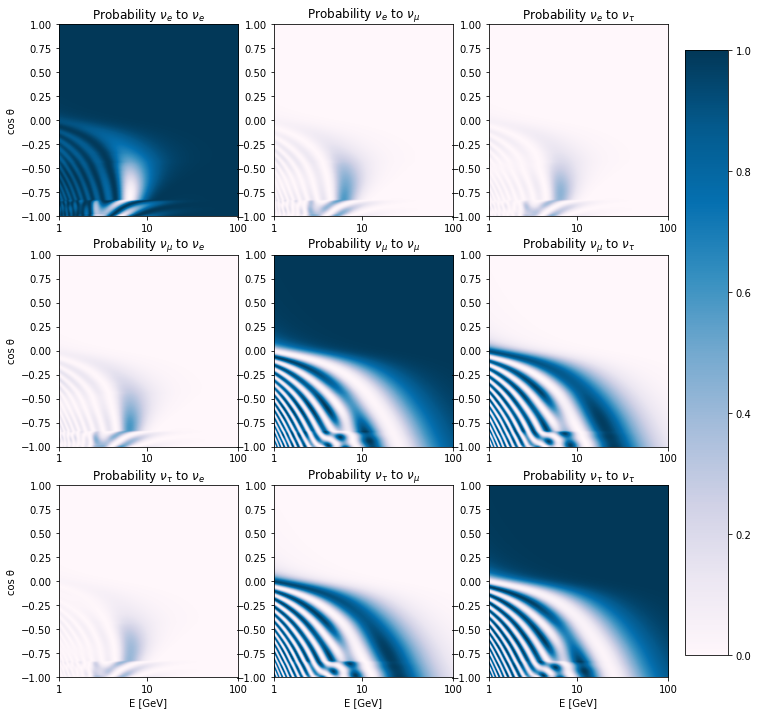

In [39]:
ticks = [1,50,100]
tick_labels = ["1","10","100"]

fig, axs = plt.subplots(3,3,figsize=(12,12))
axs[0,0].imshow(nu_e.oscillation_probability(E,costheta,12,12,1),cmap='PuBu',vmin=0,vmax=1, origin = 'lower',
                extent=(np.amin(E), np.amax(E), np.amin(costheta), np.amax(costheta)),aspect='auto')
axs[0,0].set_ylabel("cos θ")
axs[0,0].set_title(r"Probability $\nu_{e}$ to $\nu_e$")
axs[0,0].set_xticks(ticks)
axs[0,0].set_xticklabels(tick_labels)
axs[0,1].imshow(nu_e.oscillation_probability(E,costheta,12,14,1),cmap='PuBu',vmin=0,vmax=1, origin = 'lower',
                extent=(np.amin(E), np.amax(E), np.amin(costheta), np.amax(costheta)),aspect='auto')
axs[0,1].set_title(r"Probability $\nu_{e}$ to $\nu_{\mu}$")
axs[0,1].set_xticks(ticks)
axs[0,1].set_xticklabels(tick_labels)
axs[0,2].imshow(nu_e.oscillation_probability(E,costheta,12,16,1),cmap='PuBu',vmin=0,vmax=1, origin = 'lower',
                extent=(np.amin(E), np.amax(E), np.amin(costheta), np.amax(costheta)),aspect='auto')
axs[0,2].set_title(r"Probability $\nu_{e}$ to $\nu_{\tau}$")
axs[0,2].set_xticks(ticks)
axs[0,2].set_xticklabels(tick_labels)
axs[1,0].imshow(nu_e.oscillation_probability(E,costheta,14,12,1),cmap='PuBu',vmin=0,vmax=1, origin = 'lower',
                extent=(np.amin(E), np.amax(E), np.amin(costheta), np.amax(costheta)),aspect='auto')
axs[1,0].set_ylabel("cos θ")
axs[1,0].set_title(r"Probability $\nu_{\mu}$ to $\nu_e$")
axs[1,0].set_xticks(ticks)
axs[1,0].set_xticklabels(tick_labels)
axs[1,1].imshow(nu_e.oscillation_probability(E,costheta,14,14,1),cmap='PuBu',vmin=0,vmax=1, origin = 'lower',
                extent=(np.amin(E), np.amax(E), np.amin(costheta), np.amax(costheta)),aspect='auto')
axs[1,1].set_title(r"Probability $\nu_{\mu}$ to $\nu_{\mu}$")
axs[1,1].set_xticks(ticks)
axs[1,1].set_xticklabels(tick_labels)
axs[1,2].imshow(nu_e.oscillation_probability(E,costheta,14,16,1),cmap='PuBu',vmin=0,vmax=1, origin = 'lower',
                extent=(np.amin(E), np.amax(E), np.amin(costheta), np.amax(costheta)),aspect='auto')
axs[1,2].set_title(r"Probability $\nu_{\mu}$ to $\nu_{\tau}$")
axs[1,2].set_xticks(ticks)
axs[1,2].set_xticklabels(tick_labels)
axs[2,0].imshow(nu_e.oscillation_probability(E,costheta,16,12,1),cmap='PuBu',vmin=0,vmax=1, origin = 'lower',
                extent=(np.amin(E), np.amax(E), np.amin(costheta), np.amax(costheta)),aspect='auto')
axs[2,0].set_ylabel("cos θ")
axs[2,0].set_xlabel("E [GeV]")
axs[2,0].set_title(r"Probability $\nu_{\tau}$ to $\nu_e$")
axs[2,0].set_xticks(ticks)
axs[2,0].set_xticklabels(tick_labels)
axs[2,1].imshow(nu_e.oscillation_probability(E,costheta,16,14,1),cmap='PuBu',vmin=0,vmax=1, origin = 'lower',
                extent=(np.amin(E), np.amax(E), np.amin(costheta), np.amax(costheta)),aspect='auto')
axs[2,1].set_xlabel("E [GeV]")
axs[2,1].set_title(r"Probability $\nu_{\tau}$ to $\nu_{\mu}$")
axs[2,1].set_xticks(ticks)
axs[2,1].set_xticklabels(tick_labels)
cb=axs[2,2].imshow(nu_e.oscillation_probability(E,costheta,16,16,1),cmap='PuBu',vmin=0,vmax=1, origin = 'lower',
                   extent=(np.amin(E), np.amax(E), np.amin(costheta), np.amax(costheta)),aspect='auto')
axs[2,2].set_xlabel("E [GeV]")
axs[2,2].set_title(r"Probability $\nu_{\tau}$ to $\nu_{\tau}$")
axs[2,2].set_xticks(ticks)
axs[2,2].set_xticklabels(tick_labels)
fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(cb, cax=cbar_ax)
plt.show()

# Atmospheric Neutrinos

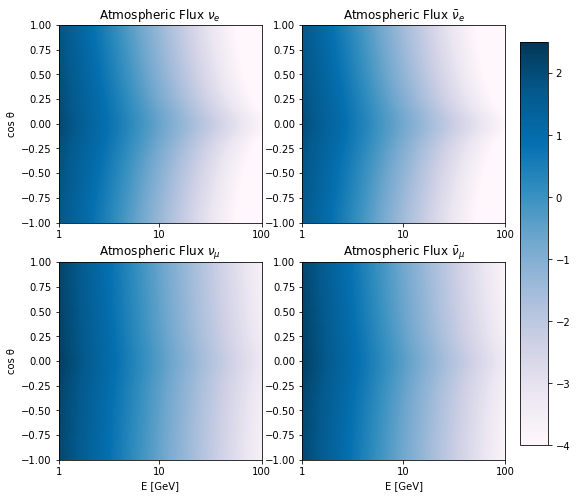

In [40]:
fig, axs = plt.subplots(2,2,figsize=(8,8))
axs[0,0].imshow(np.log10(nu_e.atmospheric_flux(E,costheta)),cmap='PuBu',vmin=-4,vmax=2.5,origin='lower',
                extent=(np.amin(E), np.amax(E), np.amin(costheta), np.amax(costheta)),aspect='auto')
axs[0,0].set_ylabel("cos θ")
axs[0,0].set_title(r"Atmospheric Flux $\nu_{e}$")
axs[0,0].set_xticks(ticks)
axs[0,0].set_xticklabels(tick_labels)
axs[1,0].imshow(np.log10(nu_m.atmospheric_flux(E,costheta)),cmap='PuBu',vmin=-4,vmax=2.5,origin='lower',
                extent=(np.amin(E), np.amax(E), np.amin(costheta), np.amax(costheta)),aspect='auto')
axs[1,0].set_xlabel("E [GeV]")
axs[1,0].set_title(r"Atmospheric Flux $\nu_{\mu}$")
axs[1,0].set_xticks(ticks)
axs[1,0].set_xticklabels(tick_labels)
axs[1,0].set_ylabel("cos θ")
axs[0,1].imshow(np.log10(nu_ae.atmospheric_flux(E,costheta)),cmap='PuBu',vmin=-4,vmax=2.5,origin='lower',
                extent=(np.amin(E), np.amax(E), np.amin(costheta), np.amax(costheta)),aspect='auto')
axs[0,1].set_title(r"Atmospheric Flux $\bar{\nu}_{e}$")
axs[0,1].set_xticks(ticks)
axs[0,1].set_xticklabels(tick_labels)
cb=axs[1,1].imshow(np.log10(nu_am.atmospheric_flux(E,costheta)),cmap='PuBu',vmin=-4,vmax=2.5,origin='lower',
                   extent=(np.amin(E), np.amax(E), np.amin(costheta), np.amax(costheta)),aspect='auto')
axs[1,1].set_title(r"Atmospheric Flux $\bar{\nu}_{\mu}$")
axs[1,1].set_xticks(ticks)
axs[1,1].set_xticklabels(tick_labels)
axs[1,1].set_xlabel("E [GeV]")
cbar_ax = fig.add_axes([0.925, 0.15, 0.05, 0.7])
fig.colorbar(cb, cax=cbar_ax)
plt.show()

# Oscillated Atmospheric Neutrinos

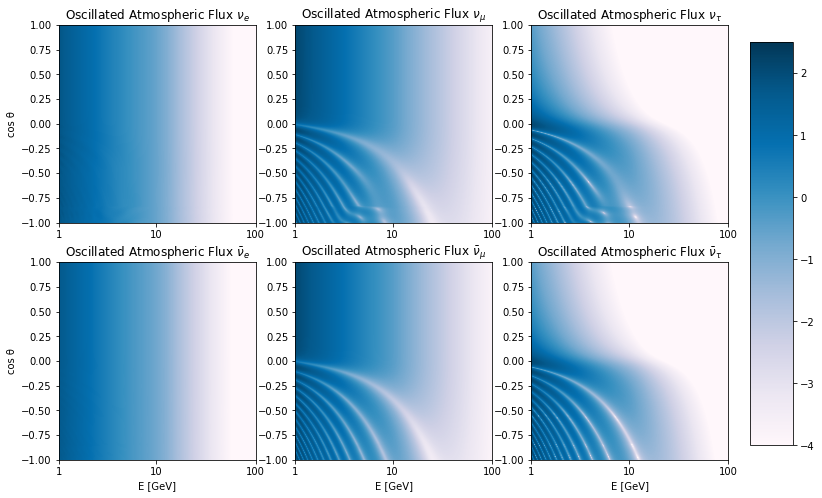

In [41]:
fig, axs = plt.subplots(2,3,figsize=(12,8))
axs[0,0].imshow(np.log10(nu_e.flux_oscillated(E,costheta)),cmap='PuBu',vmin=-4,vmax=2.5,origin='lower',
                extent=(np.amin(E), np.amax(E), np.amin(costheta), np.amax(costheta)),aspect='auto')
axs[0,0].set_ylabel("cos θ")
axs[0,0].set_title(r"Oscillated Atmospheric Flux $\nu_{e}$")
axs[0,0].set_xticks(ticks)
axs[0,0].set_xticklabels(tick_labels)
axs[1,0].imshow(np.log10(nu_ae.flux_oscillated(E,costheta)),cmap='PuBu',vmin=-4,vmax=2.5,origin='lower',
                extent=(np.amin(E), np.amax(E), np.amin(costheta), np.amax(costheta)),aspect='auto')
axs[1,0].set_xlabel("E [GeV]")
axs[1,0].set_title(r"Oscillated Atmospheric Flux $\bar{\nu}_{e}$")
axs[1,0].set_xticks(ticks)
axs[1,0].set_xticklabels(tick_labels)
axs[1,0].set_ylabel("cos θ")
axs[0,1].imshow(np.log10(nu_m.flux_oscillated(E,costheta)),cmap='PuBu',vmin=-4,vmax=2.5,origin='lower',
                extent=(np.amin(E), np.amax(E), np.amin(costheta), np.amax(costheta)),aspect='auto')
axs[0,1].set_title(r"Oscillated Atmospheric Flux $\nu_{\mu}$")
axs[0,1].set_xticks(ticks)
axs[0,1].set_xticklabels(tick_labels)
axs[1,1].imshow(np.log10(nu_am.flux_oscillated(E,costheta)),cmap='PuBu',vmin=-4,vmax=2.5,origin='lower',
                   extent=(np.amin(E), np.amax(E), np.amin(costheta), np.amax(costheta)),aspect='auto')
axs[1,1].set_title(r"Oscillated Atmospheric Flux $\bar{\nu}_{\mu}$")
axs[1,1].set_xticks(ticks)
axs[1,1].set_xticklabels(tick_labels)
axs[1,1].set_xlabel("E [GeV]")
axs[0,2].imshow(np.log10(nu_t.flux_oscillated(E,costheta)),cmap='PuBu',vmin=-4,vmax=2.5,origin='lower',
                extent=(np.amin(E), np.amax(E), np.amin(costheta), np.amax(costheta)),aspect='auto')
axs[0,2].set_title(r"Oscillated Atmospheric Flux $\nu_{\tau}$")
axs[0,2].set_xticks(ticks)
axs[0,2].set_xticklabels(tick_labels)
cb=axs[1,2].imshow(np.log10(nu_at.flux_oscillated(E,costheta)),cmap='PuBu',vmin=-4,vmax=2.5,origin='lower',
                   extent=(np.amin(E), np.amax(E), np.amin(costheta), np.amax(costheta)),aspect='auto')
axs[1,2].set_title(r"Oscillated Atmospheric Flux $\bar{\nu}_{\tau}$")
axs[1,2].set_xticks(ticks)
axs[1,2].set_xticklabels(tick_labels)
axs[1,2].set_xlabel("E [GeV]")
cbar_ax = fig.add_axes([0.925, 0.15, 0.05, 0.7])
fig.colorbar(cb, cax=cbar_ax)
plt.show()

# Cross Sections

In [42]:
bins = 20
E_e, cs_e = nu_e.cross_section_bin(bins=bins)
E_m, cs_m = nu_m.cross_section_bin(bins=bins)
E_t, cs_t = nu_t.cross_section_bin(bins=bins)
E_ae, cs_ae = nu_ae.cross_section_bin(bins=bins)
E_am, cs_am = nu_am.cross_section_bin(bins=bins)
E_at, cs_at = nu_at.cross_section_bin(bins=bins)

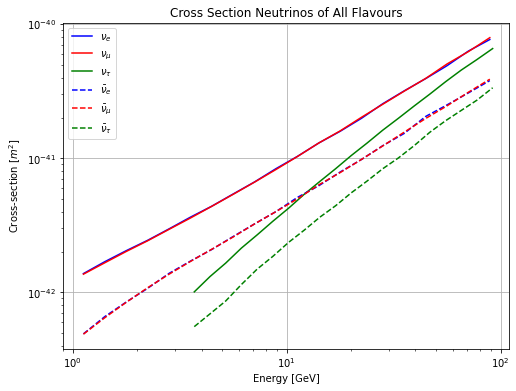

In [43]:
fig=plt.figure(figsize=(8,6))
plt.title("Cross Section Neutrinos of All Flavours")
plt.loglog(E_e, cs_e, 'blue', ls='-', label=r'$\nu_e$')
plt.loglog(E_m, cs_m, 'red', ls='-', label=r'$\nu_{\mu}$')
plt.loglog(E_t, cs_t, 'green', ls='-', label=r'$\nu_{\tau}$')
plt.loglog(E_ae, cs_ae, 'blue', ls='--', label=r'$\bar{\nu}_e$')
plt.loglog(E_am, cs_am, 'red', ls='--', label=r'$\bar{\nu}_{\mu}$')
plt.loglog(E_at, cs_at, 'green', ls='--', label=r'$\bar{\nu}_{\tau}$')
plt.xlabel("Energy [GeV]")
plt.ylabel("Cross-section [$m^2$]")
plt.xlim(0.9,110)
plt.grid()
plt.legend()
plt.show()

# Effective Volume

In [44]:
bins = 16
E_e, effvol_e = nu_e.Effective_Volume(bintype='E',bins=bins)
E_m, effvol_m = nu_m.Effective_Volume(bintype='E',bins=bins)
E_t, effvol_t = nu_t.Effective_Volume(bintype='E',bins=bins)
E_ae, effvol_ae = nu_ae.Effective_Volume(bintype='E',bins=bins)
E_am, effvol_am = nu_am.Effective_Volume(bintype='E',bins=bins)
E_at, effvol_at = nu_at.Effective_Volume(bintype='E',bins=bins)

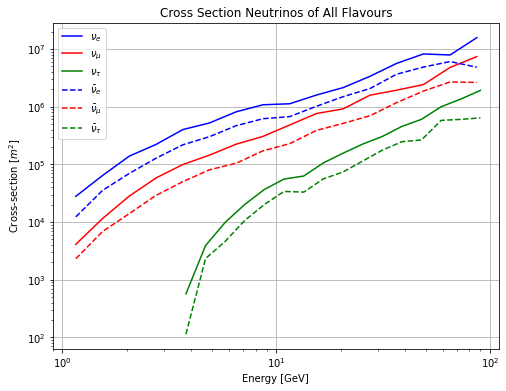

In [45]:
fig=plt.figure(figsize=(8,6))
plt.title("Cross Section Neutrinos of All Flavours")
plt.loglog(E_e, effvol_e, 'blue', ls='-', label=r'$\nu_e$')
plt.loglog(E_m, effvol_m, 'red', ls='-', label=r'$\nu_{\mu}$')
plt.loglog(E_t, effvol_t, 'green', ls='-', label=r'$\nu_{\tau}$')
plt.loglog(E_ae, effvol_ae, 'blue', ls='--', label=r'$\bar{\nu}_e$')
plt.loglog(E_am, effvol_am, 'red', ls='--', label=r'$\bar{\nu}_{\mu}$')
plt.loglog(E_at, effvol_at, 'green', ls='--', label=r'$\bar{\nu}_{\tau}$')
plt.xlabel("Energy [GeV]")
plt.ylabel("Cross-section [$m^2$]")
plt.xlim(0.9,110)
plt.grid()
plt.legend()
plt.show()

# Interaction Rate per kg

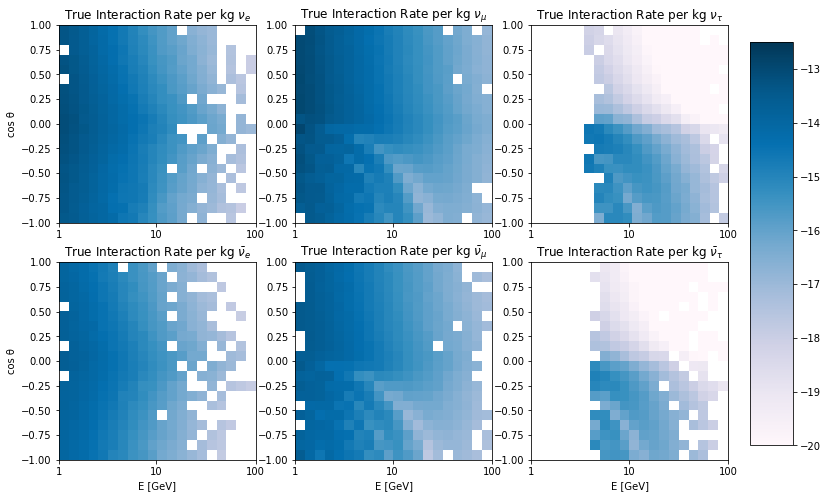

In [46]:
fig, axs = plt.subplots(2,3,figsize=(12,8))
axs[0,0].imshow(np.log10(nu_e.TrueInteractionRate_per_mass_bin(bins=20)),cmap='PuBu',vmin=-20,vmax=-12.5,
                extent=(nu_m.Emin, nu_m.Emax, nu_m.costheta_min, nu_m.costheta_max),aspect='auto')
axs[0,0].set_ylabel("cos θ")
axs[0,0].set_title(r"True Interaction Rate per kg $\nu_{e}$")
axs[0,0].set_xticks(ticks)
axs[0,0].set_xticklabels(tick_labels)
axs[1,0].imshow(np.log10(nu_ae.TrueInteractionRate_per_mass_bin(bins=20)),cmap='PuBu',vmin=-20,vmax=-12.5,
                extent=(nu_m.Emin, nu_m.Emax, nu_m.costheta_min, nu_m.costheta_max),aspect='auto')
axs[1,0].set_xlabel("E [GeV]")
axs[1,0].set_title(r"True Interaction Rate per kg $\bar{\nu}_{e}$")
axs[1,0].set_xticks(ticks)
axs[1,0].set_xticklabels(tick_labels)
axs[1,0].set_ylabel("cos θ")
axs[0,1].imshow(np.log10(nu_m.TrueInteractionRate_per_mass_bin(bins=20)),cmap='PuBu',vmin=-20,vmax=-12.5,
                extent=(nu_m.Emin, nu_m.Emax, nu_m.costheta_min, nu_m.costheta_max),aspect='auto')
axs[0,1].set_title(r"True Interaction Rate per kg $\nu_{\mu}$")
axs[0,1].set_xticks(ticks)
axs[0,1].set_xticklabels(tick_labels)
axs[1,1].imshow(np.log10(nu_am.TrueInteractionRate_per_mass_bin(bins=20)),cmap='PuBu',vmin=-20,vmax=-12.5,
                extent=(nu_m.Emin, nu_m.Emax, nu_m.costheta_min, nu_m.costheta_max),aspect='auto')
axs[1,1].set_title(r"True Interaction Rate per kg $\bar{\nu}_{\mu}$")
axs[1,1].set_xticks(ticks)
axs[1,1].set_xticklabels(tick_labels)
axs[1,1].set_xlabel("E [GeV]")
axs[0,2].imshow(np.log10(nu_t.TrueInteractionRate_per_mass_bin(bins=20)),cmap='PuBu',vmin=-20,vmax=-12.5,
                extent=(nu_t.Emin, nu_t.Emax, nu_t.costheta_min, nu_t.costheta_max),aspect='auto')
axs[0,2].set_title(r"True Interaction Rate per kg $\nu_{\tau}$")
axs[0,2].set_xticks(ticks)
axs[0,2].set_xticklabels(tick_labels)
cb=axs[1,2].imshow(np.log10(nu_at.TrueInteractionRate_per_mass_bin(bins=20)),cmap='PuBu',vmin=-20,vmax=-12.5,
                   extent=(nu_m.Emin, nu_m.Emax, nu_m.costheta_min, nu_m.costheta_max),aspect='auto')
axs[1,2].set_title(r"True Interaction Rate per kg $\bar{\nu}_{\tau}$")
axs[1,2].set_xticks(ticks)
axs[1,2].set_xticklabels(tick_labels)
axs[1,2].set_xlabel("E [GeV]")
cbar_ax = fig.add_axes([0.925, 0.15, 0.05, 0.7])
fig.colorbar(cb, cax=cbar_ax)
plt.show()

# True Interaction Rate of ORCA-115

/project/antares/jurjanbootsma/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/project/antares/jurjanbootsma/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/project/antares/jurjanbootsma/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/project/antares/jurjanbootsma/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/project/antares/jurjanbootsma/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/project/antares/jurjanbootsma/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10


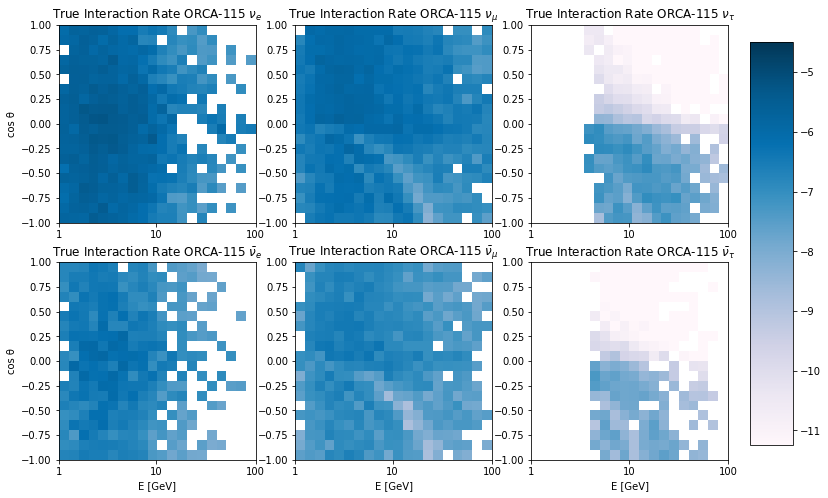

In [47]:
fig, axs = plt.subplots(2,3,figsize=(12,8))
axs[0,0].imshow(np.log10(nu_e.TrueInteractionRate_detector(bintype="2D",bins=20)),cmap='PuBu',vmin=-11.25,vmax=-4.5,
                extent=(nu_m.Emin, nu_m.Emax, nu_m.costheta_min, nu_m.costheta_max),aspect='auto')
axs[0,0].set_ylabel("cos θ")
axs[0,0].set_title(r"True Interaction Rate ORCA-115 $\nu_{e}$")
axs[0,0].set_xticks(ticks)
axs[0,0].set_xticklabels(tick_labels)
axs[1,0].imshow(np.log10(nu_ae.TrueInteractionRate_detector(bintype="2D",bins=20)),cmap='PuBu',vmin=-11.25,vmax=-4.5,
                extent=(nu_m.Emin, nu_m.Emax, nu_m.costheta_min, nu_m.costheta_max),aspect='auto')
axs[1,0].set_xlabel("E [GeV]")
axs[1,0].set_title(r"True Interaction Rate ORCA-115 $\bar{\nu}_{e}$")
axs[1,0].set_xticks(ticks)
axs[1,0].set_xticklabels(tick_labels)
axs[1,0].set_ylabel("cos θ")
axs[0,1].imshow(np.log10(nu_m.TrueInteractionRate_detector(bintype="2D",bins=20)),cmap='PuBu',vmin=-11.25,vmax=-4.5,
                extent=(nu_m.Emin, nu_m.Emax, nu_m.costheta_min, nu_m.costheta_max),aspect='auto')
axs[0,1].set_title(r"True Interaction Rate ORCA-115 $\nu_{\mu}$")
axs[0,1].set_xticks(ticks)
axs[0,1].set_xticklabels(tick_labels)
axs[1,1].imshow(np.log10(nu_am.TrueInteractionRate_detector(bintype="2D",bins=20)),cmap='PuBu',vmin=-11.25,vmax=-4.5,
                extent=(nu_m.Emin, nu_m.Emax, nu_m.costheta_min, nu_m.costheta_max),aspect='auto')
axs[1,1].set_title(r"True Interaction Rate ORCA-115 $\bar{\nu}_{\mu}$")
axs[1,1].set_xticks(ticks)
axs[1,1].set_xticklabels(tick_labels)
axs[1,1].set_xlabel("E [GeV]")
axs[0,2].imshow(np.log10(nu_t.TrueInteractionRate_detector(bintype="2D",bins=20)),cmap='PuBu',vmin=-11.25,vmax=-4.5,
                extent=(nu_t.Emin, nu_t.Emax, nu_t.costheta_min, nu_t.costheta_max),aspect='auto')
axs[0,2].set_title(r"True Interaction Rate ORCA-115 $\nu_{\tau}$")
axs[0,2].set_xticks(ticks)
axs[0,2].set_xticklabels(tick_labels)
cb=axs[1,2].imshow(np.log10(nu_at.TrueInteractionRate_detector(bintype="2D",bins=20)),cmap='PuBu',vmin=-11.25,vmax=-4.5,
                   extent=(nu_m.Emin, nu_m.Emax, nu_m.costheta_min, nu_m.costheta_max),aspect='auto')
axs[1,2].set_title(r"True Interaction Rate ORCA-115 $\bar{\nu}_{\tau}$")
axs[1,2].set_xticks(ticks)
axs[1,2].set_xticklabels(tick_labels)
axs[1,2].set_xlabel("E [GeV]")
cbar_ax = fig.add_axes([0.925, 0.15, 0.05, 0.7])
fig.colorbar(cb, cax=cbar_ax)
plt.show()

# Reconstructed Interaction Rate

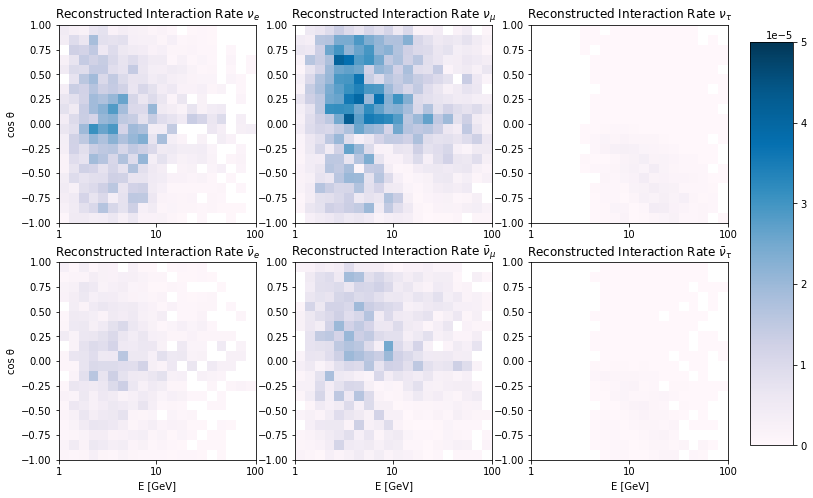

In [48]:
fig, axs = plt.subplots(2,3,figsize=(12,8))
axs[0,0].imshow(nu_e.InteractionRate_rec(bintype="2D",bins=20), cmap='PuBu', vmin=0, vmax=5*10**-5,
                   extent=(nu_m.Emin, nu_m.Emax, nu_m.costheta_min, nu_m.costheta_max), aspect='auto')
axs[0,0].set_xticks(ticks)
axs[0,0].set_xticklabels(tick_labels)
axs[0,0].set_ylabel("cos θ")
axs[0,0].set_title(r"Reconstructed Interaction Rate $\nu_{e}$")

axs[1,0].imshow(nu_ae.InteractionRate_rec(bintype="2D",bins=20), cmap='PuBu', vmin=0, vmax=5*10**-5,
                extent=(nu_m.Emin, nu_m.Emax, nu_m.costheta_min, nu_m.costheta_max), aspect='auto')
axs[1,0].set_xticks(ticks)
axs[1,0].set_xticklabels(tick_labels)
axs[1,0].set_ylabel("cos θ")
axs[1,0].set_xlabel("E [GeV]")
axs[1,0].set_title(r"Reconstructed Interaction Rate $\bar{\nu}_{e}$")

cb=axs[0,1].imshow(nu_m.InteractionRate_rec(bintype="2D",bins=20), cmap='PuBu', vmin=0, vmax=5*10**-5,
                   extent=(nu_m.Emin, nu_m.Emax, nu_m.costheta_min, nu_m.costheta_max), aspect='auto')
axs[0,1].set_xticks(ticks)
axs[0,1].set_xticklabels(tick_labels)
axs[0,1].set_title(r"Reconstructed Interaction Rate $\nu_{\mu}$")

axs[1,1].imshow(nu_am.InteractionRate_rec(bintype="2D",bins=20), cmap='PuBu', vmin=0, vmax=5*10**-5,
                extent=(nu_m.Emin, nu_m.Emax, nu_m.costheta_min, nu_m.costheta_max), aspect='auto')
axs[1,1].set_xticks(ticks)
axs[1,1].set_xticklabels(tick_labels)
axs[1,1].set_xlabel("E [GeV]")
axs[1,1].set_title(r"Reconstructed Interaction Rate $\bar{\nu}_{\mu}$")

axs[0,2].imshow(nu_t.InteractionRate_rec(bintype="2D",bins=20), cmap='PuBu', vmin=0, vmax=5*10**-5,
                extent=(nu_m.Emin, nu_m.Emax, nu_m.costheta_min, nu_m.costheta_max), aspect='auto')
axs[0,2].set_xticks(ticks)
axs[0,2].set_xticklabels(tick_labels)
axs[0,2].set_title(r"Reconstructed Interaction Rate $\nu_{\tau}$")

axs[1,2].imshow(nu_at.InteractionRate_rec(bintype="2D",bins=20), cmap='PuBu', vmin=0, vmax=5*10**-5,
                extent=(nu_m.Emin, nu_m.Emax, nu_m.costheta_min, nu_m.costheta_max), aspect='auto')
axs[1,2].set_xticks(ticks)
axs[1,2].set_xticklabels(tick_labels)
axs[1,2].set_xlabel("E [GeV]")
axs[1,2].set_title(r"Reconstructed Interaction Rate $\bar{\nu}_{\tau}$")

cbar_ax = fig.add_axes([0.925, 0.15, 0.05, 0.7])
fig.colorbar(cb, cax=cbar_ax)

plt.show()
